To get the data openstreet map is used. A bounding box which have the corner coordinates for the square of the desired area is used to get the POIs. The coordinates for Boulder are found via google maps and the link below downloads the data:
https://overpass-api.de/api/map?bbox=-105.32,39.95,-105.2,40.08

In [1]:
## Load packages
import gzip
import xml.etree.ElementTree as ET

import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import pickle5
import folium


In [2]:
def pick_from_dict(d, keys):
    return {key: d[key] for key in keys}
def merge_dicts(d1, d2):
    return dict(set(d1.items() | set(d2.items())))

In [3]:
def get_amenity(node):
    return {'amenity': next(filter(lambda child: child.attrib.get('k') == 'amenity', node)).attrib['v']}
    
    
def has_amenity_child(node):
    return any(child.attrib.get('k') == 'amenity' for child in node)


def get_pois(root):
    return pd.DataFrame(
        map(lambda node: merge_dicts(get_amenity(node), pick_from_dict(node.attrib, ['lat', 'lon', 'timestamp'])),
            filter(has_amenity_child, root.findall('node')))
    ).assign(timestamp=lambda d: pd.to_datetime(d.timestamp))\
    .sort_values(by='amenity')\
    .assign(lat=lambda df: df.lat.astype(float), lon=lambda df: df.lon.astype(float))

In [4]:
df_pois = get_pois(ET.parse('../data/poi_map').getroot())
df_pois.head()

,timestamp,lat,amenity,lon
1076,2019-04-21 06:44:06+00:00,40.073078,animal_boarding,-105.200844
1542,2018-05-20 18:35:18+00:00,40.070944,arts_centre,-105.200539
914,2019-09-07 13:29:54+00:00,40.016853,arts_centre,-105.256395
1397,2017-09-03 22:43:11+00:00,40.036770,atm,-105.252741
153,2013-02-01 23:50:13+00:00,40.008351,atm,-105.266879


In [5]:
df_pois.shape

(1936, 4)

## Aggregation of POI's

In [6]:
print("Number of different POI's: {}".format(len(df_pois['amenity'].unique())))

Number of different POI's: 69


In [7]:
df_pois['amenity'].unique()

array(['animal_boarding', 'arts_centre', 'atm', 'bank', 'bar', 'bbq',
       'bench', 'bicycle_parking', 'bicycle_rental',
       'bicycle_repair_station', 'bus_station', 'cafe', 'cafeteria',
       'car_rental', 'car_sharing', 'car_wash', 'charging_station',
       'childcare', 'clinic', 'clock', 'college', 'compost',
       'compressed_air', 'courthouse', 'coworking_space', 'dentist',
       'doctors', 'dojo', 'drinking_water', 'driving_school', 'fast_food',
       'financial_advice', 'fire_station', 'food_court', 'fountain',
       'fuel', 'hospital', 'ice_cream', 'kindergarten', 'library',
       'loading_dock', 'marketplace', 'music_school', 'nightclub',
       'parking', 'parking_entrance', 'pharmacy', 'place_of_worship',
       'police', 'polling_station', 'post_box', 'post_office',
       'prep_school', 'pub', 'public_bookcase', 'recycling', 'restaurant',
       'school', 'shelter', 'ski_rental', 'social_facility', 'taxi',
       'telephone', 'theatre', 'toilets', 'vending_mach

There are 69 so we need to choose the ones that we think would be relevant. 

In [8]:
def aggregate_amenities(df):
    def _reverse_get(dct, value):
        return next(key for key in dct if value in dct[key]) if any(value in dct[key] for key in dct) else 'other' 
    
    return df.assign(
        amenity_aggtype=df.amenity.apply(lambda amenity: _reverse_get({
            'entertainment': ['theatre', 'swingerclub', 'swimming_pool', 'stripclub', 'social_facility', 'pub', 'nightclub', 'music_venue', 'internet_cafe', 'hookah_lounge', 'games', 'gambling', 'gallery', 'erotic', 'community_centre', 'cinema', 'casino', 'bar', 'brothel','club'],
            'service': ['traffic_school', 'driving_school', 'townhall', 'studio', 'student_accomodation', 'post_box', 'post_depot', 'post_office','place_of_worship', 'photo', 'library', 'ferry_terminal', 'embassy', 'coworking_space', 'courthouse', 'bank', 'police'],
            #'charging': ['charging_station'],
            #'rental': ['car_sharing', 'bicycle_rental', 'car_rental'],
            'parking': ['parking_space', 'parking_entrance', 'parking'],
            'food': ['wine_storage', 'food_court','cafeteria','wine', 'restaurant', 'marketplace', 'ice_cream', 'feeding_place', 'fast_food', 'deli', 'biergarten', 'cafe'],
            'childcare': ['childcare','kindergarten'],
            'education': ['university', 'prep_school','school', 'research_institute', 'preschool', 'college',],
            #'events': ['events_venue', 'events_centre', 'event_venue', 'conference_centre',],
            'medical': ['pharmacy', 'hospital', 'clinic',  'doctors', 'dentist', ],
            'waste-management':['recycling','waste_disposal','waste_transfer_station']
        }, amenity))
    )


In [9]:
df = aggregate_amenities(df_pois)
df.head()

,timestamp,lat,amenity,lon,amenity_aggtype
1076,2019-04-21 06:44:06+00:00,40.073078,animal_boarding,-105.200844,other
1542,2018-05-20 18:35:18+00:00,40.070944,arts_centre,-105.200539,other
914,2019-09-07 13:29:54+00:00,40.016853,arts_centre,-105.256395,other
1397,2017-09-03 22:43:11+00:00,40.036770,atm,-105.252741,other
153,2013-02-01 23:50:13+00:00,40.008351,atm,-105.266879,other


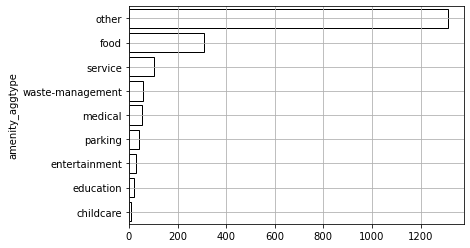

In [10]:
temp = df.groupby(['amenity_aggtype']).count().lat
temp = temp.sort_values(ascending=False)
plt.rcParams["figure.figsize"] = (6,4)
sns.barplot(x=temp.values,y=temp.index, color='white',edgecolor='k')
plt.grid()
plt.show()

When we remove the other category:

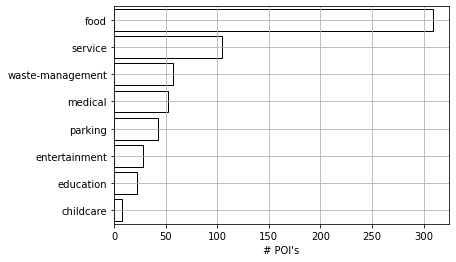

In [11]:
temp = temp[1:]
sns.barplot(x=temp.values,y=temp.index, color='white',edgecolor='k')
plt.grid()
plt.ylabel("")
plt.xlabel("# POI's")
plt.show()

In [12]:
df_POI = df[df['amenity_aggtype'] != 'other']

In [13]:
## Check which categories are in which
for typ in df_POI['amenity_aggtype'].unique():
    temp = df_POI[df_POI['amenity_aggtype'] == typ]
    print("{}: {}".format(typ,temp['amenity'].unique()))
    print("\n")

service: ['bank' 'courthouse' 'coworking_space' 'driving_school' 'library'
 'place_of_worship' 'police' 'post_box' 'post_office']


entertainment: ['bar' 'nightclub' 'pub' 'social_facility' 'theatre']


food: ['cafe' 'cafeteria' 'fast_food' 'food_court' 'ice_cream' 'marketplace'
 'restaurant']


childcare: ['childcare' 'kindergarten']


medical: ['clinic' 'dentist' 'doctors' 'hospital' 'pharmacy']


education: ['college' 'prep_school' 'school']


parking: ['parking' 'parking_entrance']


waste-management: ['recycling' 'waste_disposal']




Above 8 POI categories are shown. However only 7 are used as it later was decided to exclude `parking`. 

### Merging with Boulder dataframe

In [151]:
with open("../data/under_utilization_combinedStations_laggedV5.pkl", "rb") as fh:
    df = pickle5.load(fh)
    
df.head()

,life_time,datetime_start,datetime_end,latitude,longitude,distance_center_km,Station_Name,weekday_b,weekday_b_name,hour_b,...,near_inactivity_4H,near_charge_events_4H,near_charge_time_5H,near_charge_energy_5H,near_inactivity_5H,near_charge_events_5H,near_charge_time_6H,near_charge_energy_6H,near_inactivity_6H,near_charge_events_6H
0,928.5,2018-01-31 19:51:00,2018-02-01 11:19:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,2,Wednesday,19,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
1,363.5,2018-02-01 14:03:00,2018-02-01 20:06:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,14,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
2,6828.5,2018-02-01 21:15:00,2018-02-06 15:03:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,21,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
3,5871.5,2018-02-06 15:27:00,2018-02-10 17:18:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,1,Tuesday,15,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0
4,1454.5,2018-02-10 18:26:00,2018-02-11 18:40:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,5,Saturday,18,...,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0


In [152]:
poi_labels = df_POI['amenity_aggtype'].unique()
station_names = df['Station_Name'].unique()

In [153]:
from math import sin, cos, sqrt, atan2, radians
def distance_latlong(la1,lo1,la2,lo2):
    R = 6373
    
    lat1 = radians(la1)
    lon1 = radians(lo1)
    lat2 = radians(la2)
    lon2 = radians(lo2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance # in km

In [154]:
dictt = {}
for stat in station_names: # iterate over every station
    dictt[stat] = {}
    temp_stat = df[df['Station_Name'] == stat]
    # get station lat and long coordinates
    lat_stat = temp_stat.latitude.unique()[0]
    long_stat = temp_stat.longitude.unique()[0]
    print(stat)
    for POI in poi_labels: # iterate over every POI category
        #dictt[stat][POI] = {}
        temp_poi = df_POI[df_POI['amenity_aggtype'] == POI]
        # initialize shortest distance
        shortest_distance = 1000000
        shortest_index = None
        shortest_lat = None
        shortest_long = None
        for index, row in temp_poi.iterrows():
            # get POI point lat and long coordinates
            lat_poi = row.lat
            long_poi = row.lon
            # calculated distance from station to point
            dist = distance_latlong(lat_stat,long_stat, lat_poi, long_poi)
            if dist < shortest_distance: # if distance is shorter we update
                shortest_distance = dist
                shortest_index = index
                shortest_lat = lat_poi
                shortest_long = long_poi
    
        dictt[stat][POI] = {'dist':shortest_distance, 'idx':shortest_index,
                            'lat':shortest_lat, 'long':shortest_long}

COMM VITALITY / 1104 SPRUCE1
COMM VITALITY / 1000WALNUT
BOULDER / REC CENTER
BOULDER / BASELINE ST1
BOULDER / ATRIUM ST1
BOULDER / ALPINE ST1
COMM VITALITY / 1400 WALNUT1
BOULDER / FACILITIES ST1
COMM VITALITY / 1500PEARL
BOULDER / JUNCTION ST1
COMM VITALITY / BOULDER JCTN
COMM VITALITY / 1100WALNUT1
BOULDER / N BOULDER REC 1
BOULDER / BOULDER PARK
COMM VITALITY / 2200 BROADWAY1
BOULDER / EAST REC
BOULDERJUNCTION / JUNCTION ST1


In [155]:
stat_df_order = df['Station_Name']
for poi in poi_labels:
    temp = []
    for i in range(len(stat_df_order)):
        dist = dictt[stat_df_order[i]][poi]['dist']
        temp.append(dist)
    df[poi] = temp

In [156]:
#df.to_pickle("../data/ut_poiV6.pkl")

### Exploration of POI for the 4 stations

In [125]:
station_subset = ['BOULDER / N BOULDER REC 1', 'COMM VITALITY / 1000WALNUT', 
                  'COMM VITALITY / 1104 SPRUCE1', 'BOULDER / BASELINE ST1']
df_sub = df[df['Station_Name'].isin(station_subset)]

In [126]:
for stat in station_subset:
    print(stat)
    for poi in poi_labels:
        print("{}: {} km".format(poi,round(dictt[stat][poi]['dist'],2)))
        
    print("\n")

BOULDER / N BOULDER REC 1
service: 0.77 km
entertainment: 1.47 km
food: 0.77 km
childcare: 1.99 km
medical: 0.24 km
education: 1.82 km
parking: 1.23 km
waste-management: 0.4 km


COMM VITALITY / 1000WALNUT
service: 0.19 km
entertainment: 0.01 km
food: 0.04 km
childcare: 3.8 km
medical: 0.57 km
education: 0.33 km
parking: 0.03 km
waste-management: 1.13 km


COMM VITALITY / 1104 SPRUCE1
service: 0.06 km
entertainment: 0.11 km
food: 0.07 km
childcare: 3.52 km
medical: 0.47 km
education: 0.63 km
parking: 0.02 km
waste-management: 1.15 km


BOULDER / BASELINE ST1
service: 0.29 km
entertainment: 1.18 km
food: 0.95 km
childcare: 2.68 km
medical: 1.82 km
education: 1.03 km
parking: 1.08 km
waste-management: 0.13 km


